Import Libraries
TO DO
1) Add larger test dataset
2) Add Speed Tests
3) Create Real Polygons for Testing Purpose

In [1]:
import numpy as np
import gdal
from scipy import stats
from rasterstats import zonal_stats
from shapely.geometry import Point, Polygon
import fiona
from math import ceil,floor
import matplotlib.pyplot as plt
import datetime

<img src="data/thumb.png" alt="Drawing" style="width: 300px;"/>

In [2]:
## need to download 'http://www.landfire.gov/bulk/downloadfile.php?TYPE=nlcd2011&FNAME=nlcd_2011_impervious_2011_edition_2014_10_10.zip' and extract to /data
Grid_Name = "data\\nlcd_2011_impervious_2011_edition_2014_10_cbw.img"
Shapefile_Name = "test\\testPolyCBWall.shp"

In [3]:
class dtFZS:
    def __init__(self, img):

        self.r = gdal.Open(Grid_Name)
        self.g = np.array(self.r.GetRasterBand(1).ReadAsArray())
        
        self.clSze = self.r.GetGeoTransform()[1]
        self.ulX = self.r.GetGeoTransform()[0]
        self.ulY = self.r.GetGeoTransform()[3]
        
        self.brX = (self.g.shape[0] * self.clSze) + self.ulX
        self.brY = self.ulY - (self.g.shape[0] * self.clSze)   
        
        self.geo = self.r.GetGeoTransform()
        
        def dtFZS(g,out):
            for xw in range(0,self.g.shape[1]):
                ##print(xw/g.shape[1])
                for yw in range(0,self.g.shape[0]):
                    out[yw,xw] = out[yw-1,xw] + self.g[yw,xw]

                    
        self.data = np.zeros(self.g.shape,dtype='uint64')
        
        dtFZS(self.g,self.data)

In [4]:
## Create Class for this grid
## Takes 16 minutes on Scott's machine
print(datetime.datetime.now())
dFZS = dtFZS(Grid_Name)
print(datetime.datetime.now())

2018-10-17 09:49:52.090125
2018-10-17 09:55:40.094899


Create Helper Functions to move between world and grid cordinates

In [5]:
## Input (world cords; x1, x2, Grid Upper Left, and Cellsize)
## Returns (grid cords; list(x))
## x1 and x2 represent vertexes on a polygon in order

def x_world_to_grid(wx1,wx2,dtFZS):
    
    x1a = min(wx1,wx2)
    x2a = max(wx1,wx2)
    
    xstart = ceil  ((x1a - dtFZS.ulX - (dtFZS.clSze/2)) / dtFZS.clSze)
    xstop =  floor ((x2a - dtFZS.ulX - (dtFZS.clSze/2)) / dtFZS.clSze)

    return(list(range(xstart,xstop+1)))

In [6]:
## Input (grid cords; list(x))
## Returns(world cords centroid ;(list(X)))

def x_grid_to_world(gx,dtFZS):
    return [i * dtFZS.clSze + dtFZS.ulX + (dtFZS.clSze/2) for i in gx]

In [7]:
## Input(world cords centroid ;(list(X)))
## Returns(world cords centroid ;(list(y)))

def y_world_pred(wx1,wx2,wy1,wy2,wxpred):
    slope = 0;
    if (wx1 > wx2):
        wx1,wx2,wy1,wy2 = wx2,wx1,wy2,wy1
    if(wx1 != wx2):    
        slope = (wy2-wy1)/(wx2-wx1)

    return [(slope * (i-wx1)) + wy1 for i in wxpred]

In [8]:
## Input(world cords centroid ;(list(y)))
## Returns (grid cords; list(y))

def y_world_to_grid(wypred,dtFZS):
        return [floor((dtFZS.ulY - i - (dtFZS.clSze/2)) / dtFZS.clSze ) for i in wypred] 

In [9]:
## Input(world Cords for 2 vertexes on a polygon, TL corner of grid, and cellsize)
## Returns(y,x grid cords)

def xy_grid(wx1,wx2,wy1,wy2,dtFZS):
    xgrid  = x_world_to_grid(wx1,wx2,dtFZS)
    wxpred = x_grid_to_world(xgrid,dtFZS)  
    wypred = y_world_pred(wx1,wx2,wy1,wy2,wxpred)
    ygrid  = y_world_to_grid(wypred,dtFZS)
    
    ## Remove negative arrays above
    idx = np.array([True if i >= 0 else False for i in ygrid],dtype=bool)
    
    xgrid = np.array(xgrid)[idx]
    ygrid = np.array(ygrid)[idx]
    
    cords = ((ygrid,xgrid))
    return cords

In [10]:
## Input(list of cords in world, summed down grid, real-world grid tl, cllSze)
## Output Sum v in polygon

def FstZS(feat,DS_FstZS):
    v = feat['geometry']['coordinates'][0]  #have not tested
    total = 0;    
    for p in range(1,(len(v)+0)):
        if v[p][0] > v[p-1][0]:
            cords = xy_grid(v[p][0],v[p-1][0],v[p][1],v[p-1][1],DS_FstZS)
            if len(cords[0]) > 0:
                total -= np.sum(DS_FstZS.data[cords])
        elif v[p][0] < v[p-1][0]: 
            cords = xy_grid(v[p][0],v[p-1][0],v[p][1],v[p-1][1],DS_FstZS)
            if len(cords[0]) > 0:
                total += np.sum(DS_FstZS.data[cords])
    return int(total)

In [11]:
## Input(fiona geometry)
## Returns a tuple with the FstZS and rasterstats output

def test(feat):
    
    FstZSout = FstZS(feat, dFZS)
    Rastsout = zonal_stats(feat, Grid_Name,stats= "sum", nodata=None)

    return (float(FstZSout) , float(Rastsout[0]['sum']) )

In [12]:
## Loops over input shapefile polygons and runs the test function on each

maxHucLevel = 4

tst = list()

for feat in fiona.open(Shapefile_Name):
    if feat['properties']['hucLevel'] >= maxHucLevel:
        result = test(feat)
        tst.append(result)
        print('completed hucLevel:',feat['properties']['hucLevel'],'results:',result)
        

C:\Users\marsmith\AppData\Local\Continuum\anaconda3\lib\site-packages\rasterstats\main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
C:\Users\marsmith\AppData\Local\Continuum\anaconda3\lib\site-packages\rasterstats\io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


completed hucLevel: 4 results: (75097455.0, 75097455.0)
completed hucLevel: 4 results: (138308609.0, 138308609.0)
completed hucLevel: 4 results: (137562599.0, 137562599.0)
completed hucLevel: 4 results: (113967403.0, 113967403.0)
completed hucLevel: 6 results: (75097455.0, 75097455.0)
completed hucLevel: 6 results: (15682206.0, 15682206.0)
completed hucLevel: 6 results: (43807532.0, 43807532.0)
completed hucLevel: 6 results: (75733292.0, 75733292.0)
completed hucLevel: 8 results: (30722824.0, 30722824.0)
completed hucLevel: 8 results: (2307558.0, 2307558.0)
completed hucLevel: 8 results: (7606454.0, 7606454.0)
completed hucLevel: 8 results: (3527751.0, 3527751.0)
completed hucLevel: 10 results: (463238.0, 463238.0)
completed hucLevel: 10 results: (355028.0, 355028.0)
completed hucLevel: 10 results: (6180231.0, 6180231.0)
completed hucLevel: 10 results: (457054.0, 457054.0)
completed hucLevel: 12 results: (57067.0, 57067.0)
completed hucLevel: 12 results: (86581.0, 86581.0)
completed hu

[(75097455.0, 75097455.0), (138308609.0, 138308609.0), (137562599.0, 137562599.0), (113967403.0, 113967403.0), (75097455.0, 75097455.0), (15682206.0, 15682206.0), (43807532.0, 43807532.0), (75733292.0, 75733292.0), (30722824.0, 30722824.0), (2307558.0, 2307558.0), (7606454.0, 7606454.0), (3527751.0, 3527751.0), (463238.0, 463238.0), (355028.0, 355028.0), (6180231.0, 6180231.0), (457054.0, 457054.0), (57067.0, 57067.0), (86581.0, 86581.0), (38039.0, 38039.0), (163525.0, 163525.0)]


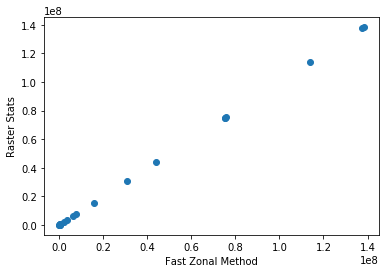

In [13]:
print(tst)
plt.scatter(y=[t[1] for t in tst],x= [t[0] for t in tst])
plt.xlabel("Fast Zonal Method")
plt.ylabel("Raster Stats")              
plt.show()   